In [10]:
import sys, os
from pathlib import Path
import pandas as pd
import numpy as np
# !pip install --upgrade typing_extensions
# !pip install openai
from openai import OpenAI
from dotenv import load_dotenv

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data" / "processed"


In [11]:
from src.models.baseline import train_logreg, evaluate
from src.models.conformal_prediction import calibrate_threshold, cp_partition, summarize_counts
from src.models.expert_integration import (
    format_case_row, FewShotExample, build_fewshot_block,
    call_gpt_batch, stratified_sample_U
)
from src.evaluation.metrics import confusion_from_preds, sensitivity_specificity, wilson_ci, new_errors

train = pd.read_pickle(DATA_DIR / "train.pkl")
calib = pd.read_pickle(DATA_DIR / "calib.pkl")
test  = pd.read_pickle(DATA_DIR / "test.pkl")

pipe = train_logreg(train)

m_test, proba_test, yhat_test = evaluate(pipe, test, threshold=0.5)
FN_baseline = m_test["FN"]
print("Baseline metrics:", m_test)

Baseline metrics: {'ACC': 0.93, 'AUROC': 0.9842910293509715, 'TP': 53, 'FP': 1, 'TN': 40, 'FN': 6, 'RECALL': 0.8983050847457474, 'PRECISION': 0.9814814814814633, 'F1': 0.9380530973451244}


In [3]:
alphas = [0.05, 0.10, 0.15, 0.20, 0.30]
records = []

for a in alphas:
    q = calibrate_threshold(pipe, calib, alpha=a)
    out = cp_partition(pipe, test, q)
    cnts = summarize_counts(out["y_true"], out["y_pred"], out["region"])
    cnts["alpha"] = a
    cnts["q"] = q
    cnts["FN_baseline"] = FN_baseline
    records.append(cnts)

df_cp = pd.DataFrame(records)
df_cp

,TP_confident,FN_confident,FP_confident,TN_confident,U_pos,U_neg,C_size,U_size,alpha,q,FN_baseline
0,53,6,1,40,0,0,100,0,0.05,0.685680,6
1,53,6,1,40,0,0,100,0,0.10,0.528078,6
2,49,3,1,39,7,1,92,8,0.15,0.393180,6
3,47,1,0,34,11,7,82,18,0.20,0.209705,6
4,45,1,0,26,13,15,72,28,0.30,0.109941,6


In [4]:
def new_errors(FN_confident, FP_confident, U_pos, U_neg, s, t):
    FN_new = FN_confident + (1 - s) * U_pos
    FP_new = FP_confident + (1 - t) * U_neg
    return FN_new, FP_new

df_cp["FN_oracle"], df_cp["FP_oracle"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=1.0, t=1.0), axis=1))

s_gpt, t_gpt = 0.9, 0.85
df_cp["FN_gpt"], df_cp["FP_gpt"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=s_gpt, t=t_gpt), axis=1))

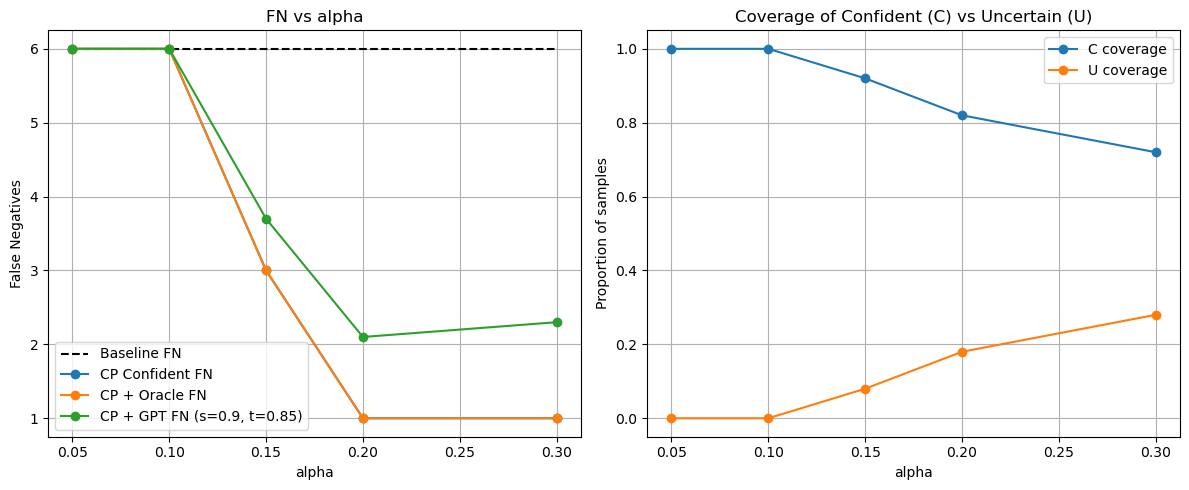

In [5]:
import matplotlib.pyplot as plt
from pathlib import Path

FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def new_errors(FN_confident, FP_confident, U_pos, U_neg, s, t):
    FN_new = FN_confident + (1 - s) * U_pos
    FP_new = FP_confident + (1 - t) * U_neg
    return FN_new, FP_new

df_cp["FN_oracle"], df_cp["FP_oracle"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=1.0, t=1.0), axis=1))

s_gpt, t_gpt = 0.9, 0.85
df_cp["FN_gpt"], df_cp["FP_gpt"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=s_gpt, t=t_gpt), axis=1))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(df_cp["alpha"], df_cp["FN_baseline"], "--", label="Baseline FN", color="black")
axes[0].plot(df_cp["alpha"], df_cp["FN_confident"], "o-", label="CP Confident FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_oracle"], "o-", label="CP + Oracle FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_gpt"], "o-", label=f"CP + GPT FN (s={s_gpt}, t={t_gpt})")
axes[0].set_xlabel("alpha")
axes[0].set_ylabel("False Negatives")
axes[0].set_title("FN vs alpha")
axes[0].legend()
axes[0].grid(True)

total = len(test)
axes[1].plot(df_cp["alpha"], df_cp["C_size"]/total, "o-", label="C coverage")
axes[1].plot(df_cp["alpha"], df_cp["U_size"]/total, "o-", label="U coverage")
axes[1].set_xlabel("alpha")
axes[1].set_ylabel("Proportion of samples")
axes[1].set_title("Coverage of Confident (C) vs Uncertain (U)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

out_path = FIG_DIR / "cp_fn_coverage.png"
plt.savefig(out_path, dpi=200)
plt.show()

In [6]:
%load_ext autoreload
%autoreload 2

import sys, os, json, numpy as np, pandas as pd
from pathlib import Path
PROJECT_ROOT = Path(os.getcwd()).resolve().parent
sys.path.append(str(PROJECT_ROOT))

from src.models.baseline import train_logreg, evaluate
from src.models.conformal_prediction import calibrate_threshold, cp_partition, summarize_counts
from src.models.expert_integration import (
    format_case_row, FewShotExample, build_fewshot_block,
    call_gpt_batch, stratified_sample_U
)
from src.evaluation.metrics import confusion_from_preds, sensitivity_specificity, wilson_ci, new_errors

DATA_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR  = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [14]:
out = cp_partition(pipe, test, q)
test_u = test[out["region"] == "U"].copy()
print("Test-U size:", len(test_u), "\nLabel counts:\n", test_u["glaucoma"].value_counts())

out_calib = cp_partition(pipe, calib, q)
calib_u = calib[out_calib["region"] == "U"].copy()
dev_u, _ = stratified_sample_U(calib_u, n_per_class=4, seed=42)

fewshots = []
for _, row in dev_u.iterrows():
    case_card = format_case_row(row)
    fewshots.append(FewShotExample(case_card=case_card, label=int(row["glaucoma"])))
fewshot_block = build_fewshot_block(fewshots)
print(f"Few-shot examples: {len(fewshots)}")

Test-U size: 28 
Label counts:
 glaucoma
0    15
1    13
Name: count, dtype: int64
Few-shot examples: 8


In [16]:
load_dotenv()
client = OpenAI()

resp = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.2,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Say hello in JSON: {\"greeting\": ...}"}
    ]
)


case_cards = [format_case_row(r) for _, r in test_u.iterrows()]
gpt_out = call_gpt_batch(client, model='gpt-4o-mini', cases=case_cards,
                         fewshot_block=fewshot_block, temperature=0.2)

In [17]:
preds = []
for item in gpt_out:
    try:
        preds.append(int(item["prediction"]))
    except:
        preds.append(None)

y_true = test_u["glaucoma"].astype(int).to_numpy()
mask_valid = [p is not None for p in preds]
y_true_eval = y_true[mask_valid]
y_pred_eval = [p for p in preds if p is not None]

print(f"Parsed {len(y_pred_eval)}/{len(y_true)} predictions")

cm = confusion_from_preds(y_true_eval, y_pred_eval)
s, t = sensitivity_specificity(cm)

s_ci = wilson_ci(s, (y_true_eval==1).sum())
t_ci = wilson_ci(t, (y_true_eval==0).sum())

print("Confusion:", cm)
print(f"Sensitivity: {s:.3f} [{s_ci[0]:.3f}, {s_ci[1]:.3f}]")
print(f"Specificity: {t:.3f} [{t_ci[0]:.3f}, {t_ci[1]:.3f}]")

Parsed 28/28 predictions
Confusion: {'TP': 10, 'TN': 10, 'FP': 5, 'FN': 3}
Sensitivity: 0.769 [0.497, 0.918]
Specificity: 0.667 [0.417, 0.848]


In [18]:
df_cp["FN_gpt_meas"], df_cp["FP_gpt_meas"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=s, t=t), axis=1
))
df_cp

,TP_confident,FN_confident,FP_confident,TN_confident,U_pos,U_neg,C_size,U_size,alpha,q,FN_baseline,FN_oracle,FP_oracle,FN_gpt,FP_gpt,FN_gpt_meas,FP_gpt_meas
0,53,6,1,40,0,0,100,0,0.05,0.685680,6,6.0,1.0,6.0,1.00,6.000000,1.000000
1,53,6,1,40,0,0,100,0,0.10,0.528078,6,6.0,1.0,6.0,1.00,6.000000,1.000000
2,49,3,1,39,7,1,92,8,0.15,0.393180,6,3.0,1.0,3.7,1.15,4.615385,1.333333
3,47,1,0,34,11,7,82,18,0.20,0.209705,6,1.0,0.0,2.1,1.05,3.538462,2.333333
4,45,1,0,26,13,15,72,28,0.30,0.109941,6,1.0,0.0,2.3,2.25,4.000000,5.000000


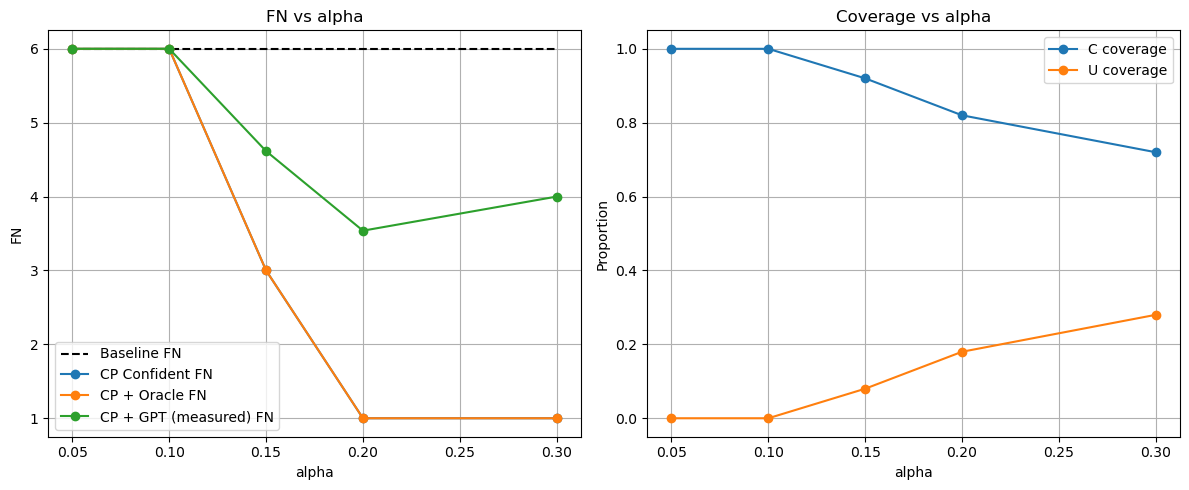

Saved figure to: /Users/jasondai/Desktop/uncertainty-aware-medAI/reports/figures/cp_fn_gpt_measured.png


In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# FN vs alpha
axes[0].plot(df_cp["alpha"], df_cp["FN_baseline"], "--", color="black", label="Baseline FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_confident"], "o-", label="CP Confident FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_oracle"], "o-", label="CP + Oracle FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_gpt_meas"], "o-", label="CP + GPT (measured) FN")

axes[0].set_title("FN vs alpha"); axes[0].set_xlabel("alpha"); axes[0].set_ylabel("FN")
axes[0].grid(True); axes[0].legend()

# Coverage
total = len(test)
axes[1].plot(df_cp["alpha"], df_cp["C_size"]/total, "o-", label="C coverage")
axes[1].plot(df_cp["alpha"], df_cp["U_size"]/total, "o-", label="U coverage")
axes[1].set_title("Coverage vs alpha"); axes[1].set_xlabel("alpha"); axes[1].set_ylabel("Proportion")
axes[1].grid(True); axes[1].legend()

plt.tight_layout()
out_path = FIG_DIR / "cp_fn_gpt_measured.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved figure to:", out_path)